A:

In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from math import exp

In [3]:
data = loadmat('data2.mat')
x_train = data['X']
y = data['y']
y = y.reshape(-1)
y_train = np.ones(len(y), dtype=int)

B:

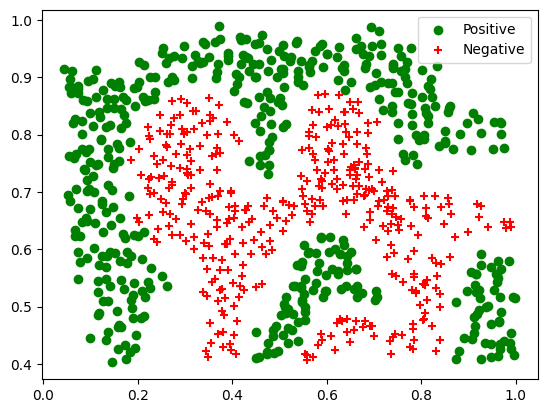

In [4]:
y_train[y == 0] = -1
y_train

positive = x_train[y_train == 1]
negative = x_train[y_train == -1]

plt.scatter(positive[:, 0], positive[:, 1], color='green', marker='o', label='Positive')
plt.scatter(negative[:, 0], negative[:, 1], color='red', marker='+', label='Negative')

plt.legend()
plt.show()

C:

In [5]:
def rbf_kernel(x1, x2, gamma=0.01):
    return exp(-gamma * np.linalg.norm(np.array(x1)-np.array(x2))**2)

D:

In [6]:
model = ConcreteModel()

In [7]:
N = len(x_train)
model.alpha = Var(range(N), within=NonNegativeReals)

In [8]:
model.obj = Objective(expr=sum(model.alpha[i] for i in range(N)) - 0.5 * 
                      sum(model.alpha[i]*model.alpha[j]*y_train[i]*y_train[j]*rbf_kernel(x_train[i], x_train[j])
                                                                             for i in range(N) for j in range(N)), sense=maximize)

In [9]:
model.constraints = ConstraintList()
for i in range(N):
    model.constraints.add(expr=model.alpha[i] <= 1)
model.constraints.add(expr=sum(model.alpha[i]*y_train[i] for i in range(N)) == 0)

In [10]:
solver = SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 864, 'Number of variables': 863, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 17.899298667907715}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [11]:
alpha = np.array([model.alpha[i].value for i in range(N)])
support_vectors = x_train[alpha > 1e-5]

In [12]:
sv_indices = np.where(alpha > 1e-5)[0]

print("Number of support vectors: ", len(sv_indices))

print("Alpha values of support vectors: ", alpha[sv_indices])


Number of support vectors:  769
Alpha values of support vectors:  [9.99999924e-01 9.99999896e-01 9.99999837e-01 9.99999597e-01
 9.99999451e-01 9.99999821e-01 9.99999884e-01 9.99999912e-01
 9.99999913e-01 9.99999895e-01 9.99999860e-01 9.99999844e-01
 9.99999908e-01 9.99999926e-01 9.99999936e-01 9.99999915e-01
 9.99999878e-01 9.99999392e-01 9.99999434e-01 9.99999730e-01
 9.99999828e-01 9.99999675e-01 9.99999028e-01 9.99997353e-01
 9.99999634e-01 9.99999738e-01 9.99999797e-01 9.99999850e-01
 9.99999892e-01 9.99999901e-01 9.99999908e-01 9.99999929e-01
 9.99999938e-01 9.99999935e-01 9.99999911e-01 9.99999903e-01
 9.99999862e-01 9.99999795e-01 9.99999667e-01 9.99999313e-01
 9.99996921e-01 9.99999035e-01 9.99999688e-01 9.99999770e-01
 9.99999365e-01 9.99998397e-01 9.99995922e-01 9.99999275e-01
 9.99988324e-01 1.57217986e-04 9.99998860e-01 9.99999389e-01
 9.99999651e-01 9.99999718e-01 9.99999790e-01 9.99999817e-01
 9.99999833e-01 9.99999844e-01 9.99999869e-01 9.99999891e-01
 9.99999899e-01 9.9

E:

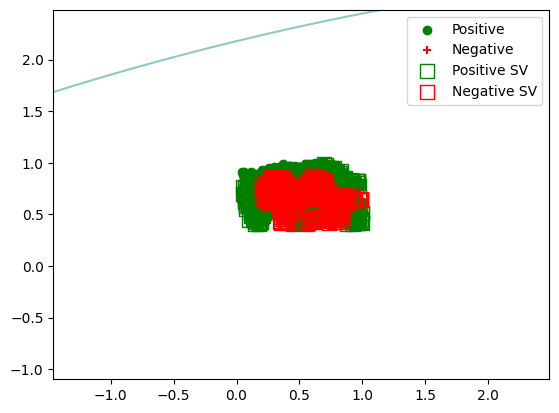

In [13]:
def plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices, gamma=0.01):
    x_min, x_max = x_train[:, 0].min() - 1.5, x_train[:, 0].max() + 1.5
    y_min, y_max = x_train[:, 1].min() - 1.5, x_train[:, 1].max() + 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x_test = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = sum(alpha[k] * y_train[k] * rbf_kernel(x_train[k], x_test) for k in sv_indices)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='green', marker='o', label='Positive')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='red', marker='+', label='Negative')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == 1][:, 0], x_train[sv_indices][y_train[sv_indices] == 1][:, 1],
                s=100, facecolors='none', edgecolors='green', marker='s', label='Positive SV')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == -1][:, 0], x_train[sv_indices][y_train[sv_indices] == -1][:, 1],
                s=100, facecolors='none', edgecolors='red', marker='s', label='Negative SV')
    plt.legend()
    plt.show()

plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices)

because of the gamma value the decision boundary is way bigger than what we expected

this is the zoomed in plot

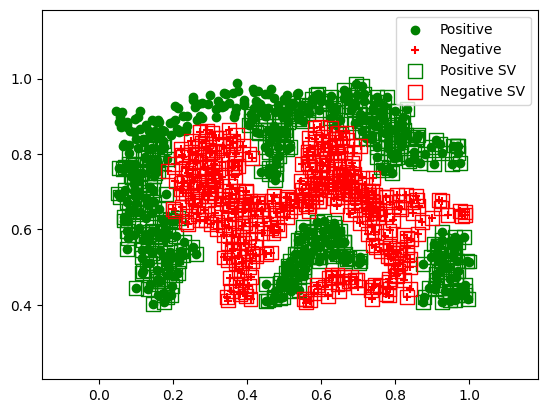

In [14]:
def plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices, gamma=0.01):
    # Generate a mesh grid for visualization
    x_min, x_max = x_train[:, 0].min() - 0.2, x_train[:, 0].max() + 0.2
    y_min, y_max = x_train[:, 1].min() - 0.2, x_train[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x_test = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = sum(alpha[k] * y_train[k] * rbf_kernel(x_train[k], x_test) for k in sv_indices)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='green', marker='o', label='Positive')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='red', marker='+', label='Negative')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == 1][:, 0], x_train[sv_indices][y_train[sv_indices] == 1][:, 1],
                s=100, facecolors='none', edgecolors='green', marker='s', label='Positive SV')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == -1][:, 0], x_train[sv_indices][y_train[sv_indices] == -1][:, 1],
                s=100, facecolors='none', edgecolors='red', marker='s', label='Negative SV')
    plt.legend()
    plt.show()

plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices)

F:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

G:

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [18]:
gammas = [0.1, 1, 10, 100, 1000]
Cs = [0.1, 1, 10, 100, 1000]

Gamma: 0.1, C: 0.1, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


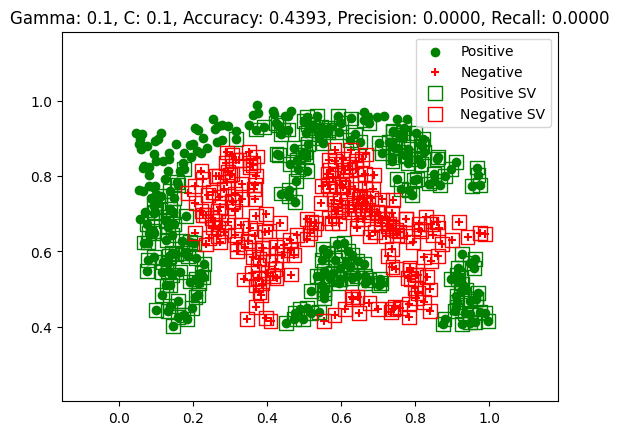

Gamma: 0.1, C: 1, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


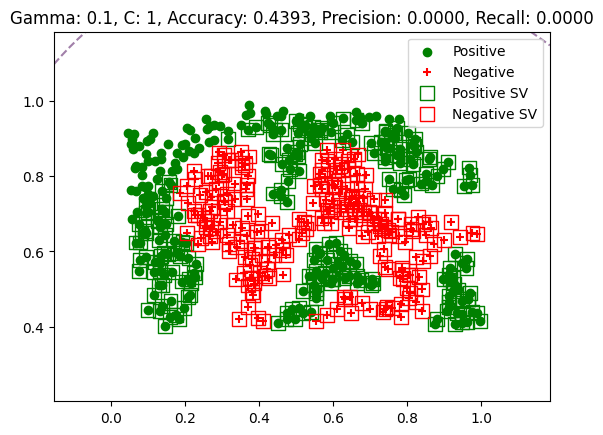

Gamma: 0.1, C: 10, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


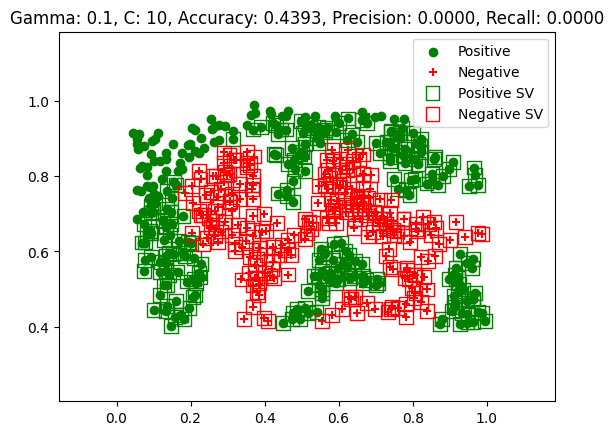

Gamma: 0.1, C: 100, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


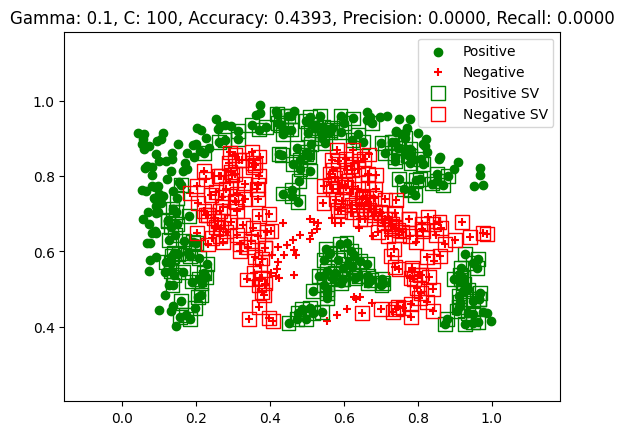

Gamma: 0.1, C: 1000, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


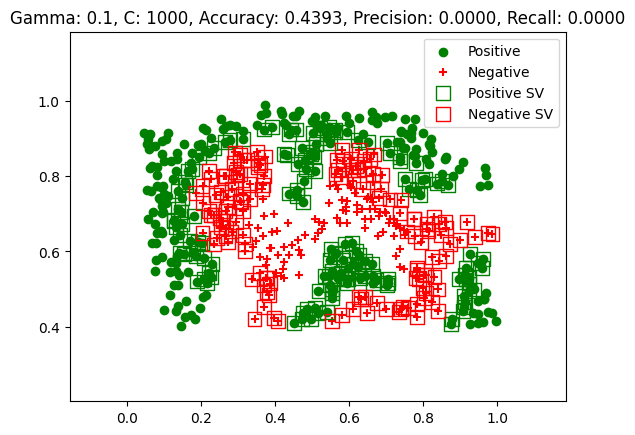

Gamma: 1, C: 0.1, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


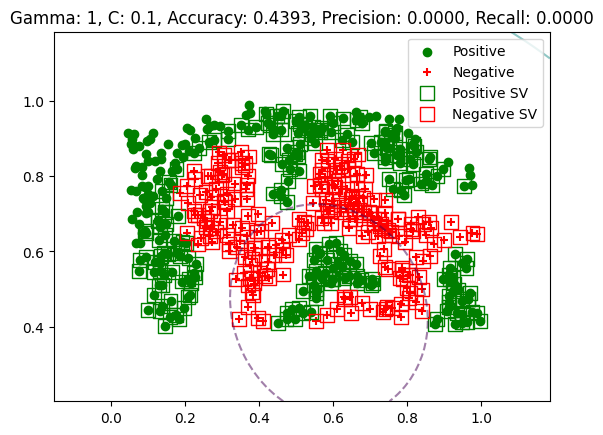

Gamma: 1, C: 1, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


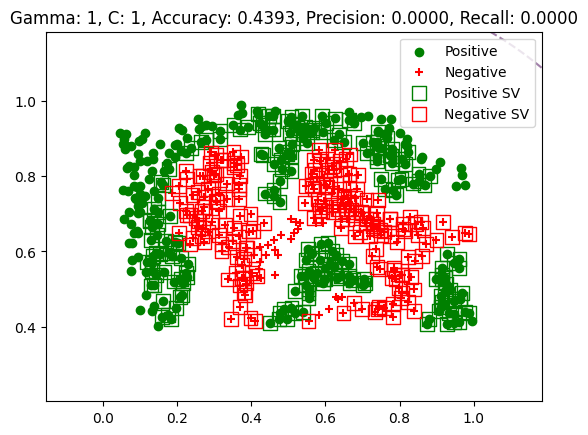

Gamma: 1, C: 10, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


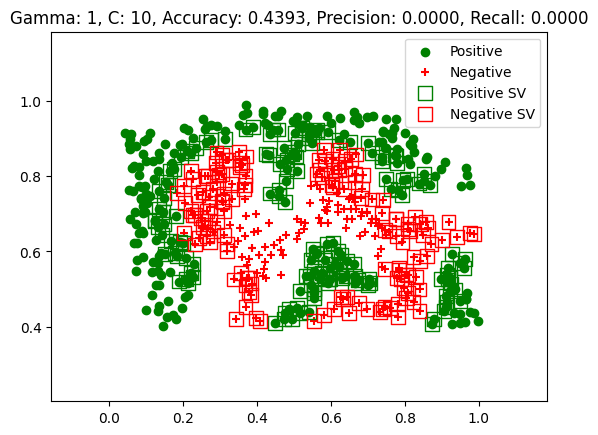

Gamma: 1, C: 100, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


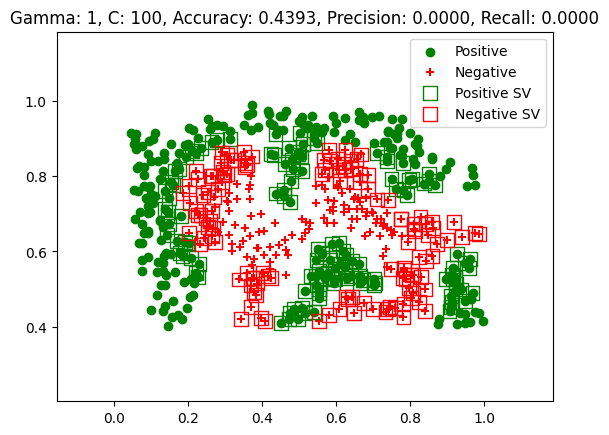

Gamma: 1, C: 1000, Accuracy: 0.4393, Precision: 0.0000, Recall: 0.0000


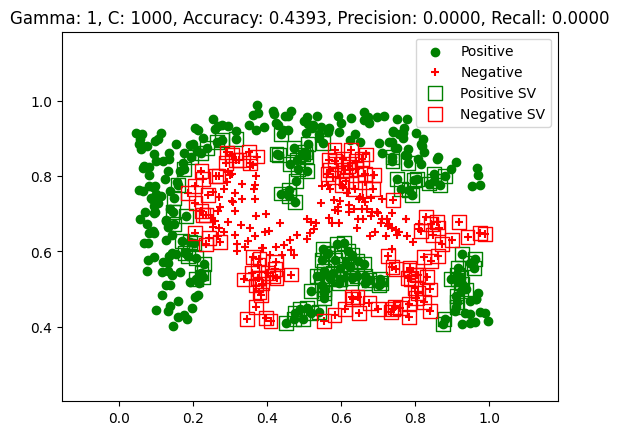

Gamma: 10, C: 0.1, Accuracy: 0.5780, Precision: 1.0000, Recall: 0.2474


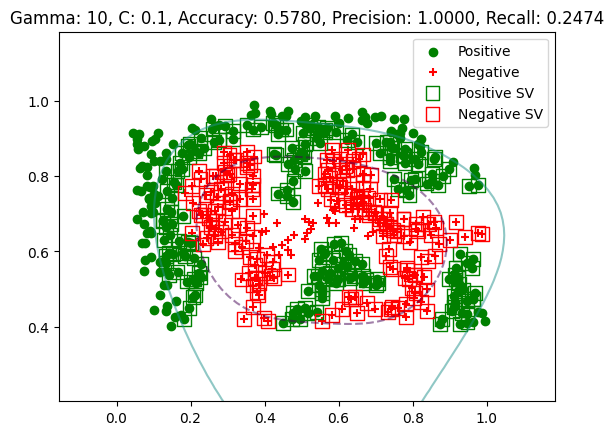

Gamma: 10, C: 1, Accuracy: 0.4913, Precision: 1.0000, Recall: 0.0928


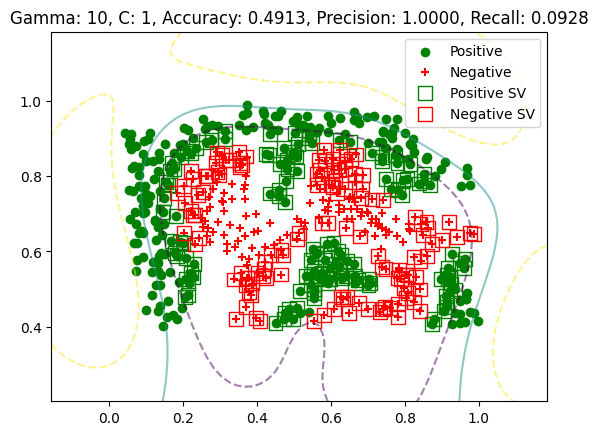

Gamma: 10, C: 10, Accuracy: 0.5202, Precision: 1.0000, Recall: 0.1443


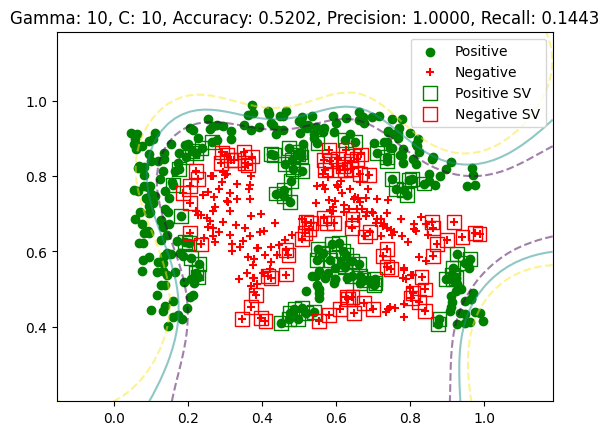

Gamma: 10, C: 100, Accuracy: 0.5434, Precision: 1.0000, Recall: 0.1856


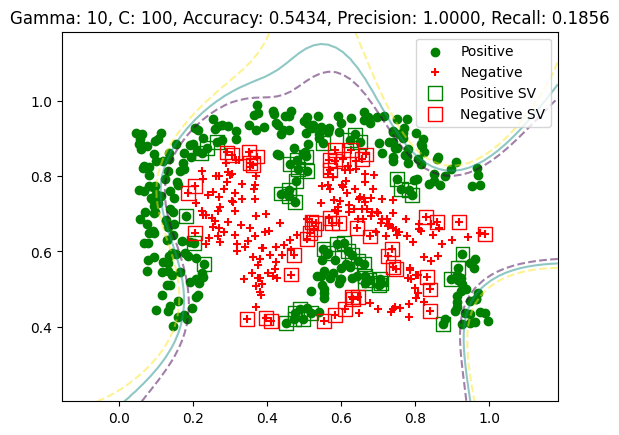

Gamma: 10, C: 1000, Accuracy: 0.5202, Precision: 1.0000, Recall: 0.1443


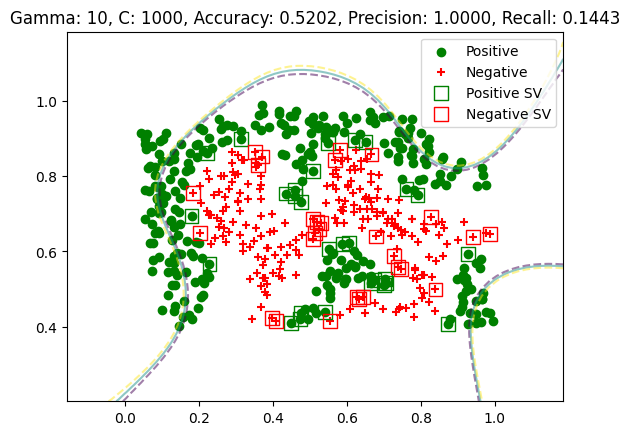

Gamma: 100, C: 0.1, Accuracy: 0.9480, Precision: 0.9783, Recall: 0.9278


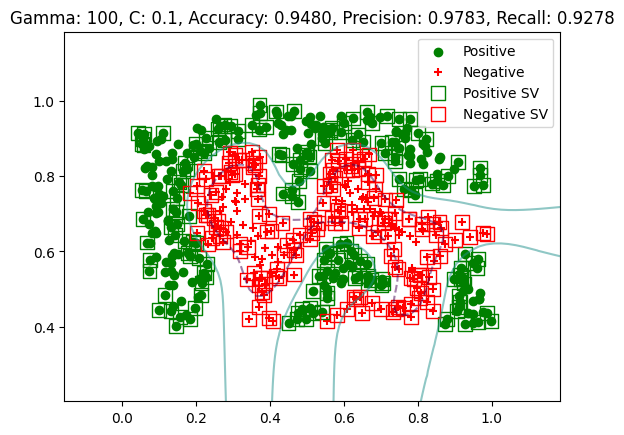

Gamma: 100, C: 1, Accuracy: 0.9769, Precision: 0.9794, Recall: 0.9794


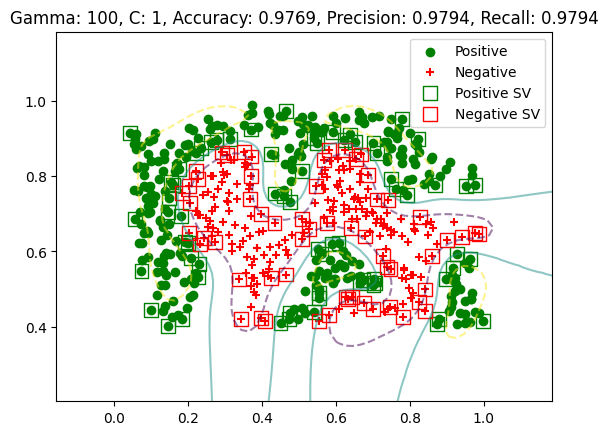

Gamma: 100, C: 10, Accuracy: 0.9769, Precision: 0.9794, Recall: 0.9794


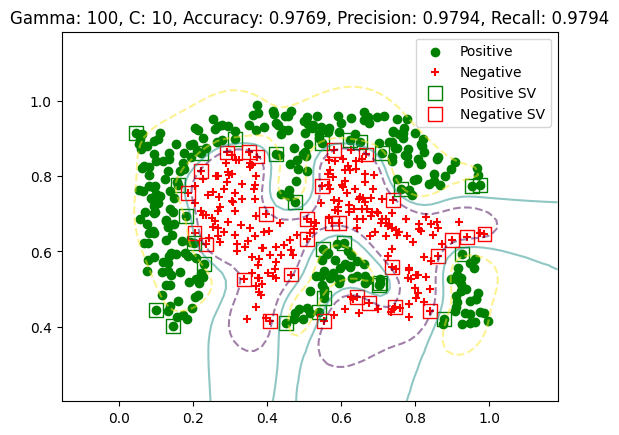

Gamma: 100, C: 100, Accuracy: 0.9827, Precision: 0.9896, Recall: 0.9794


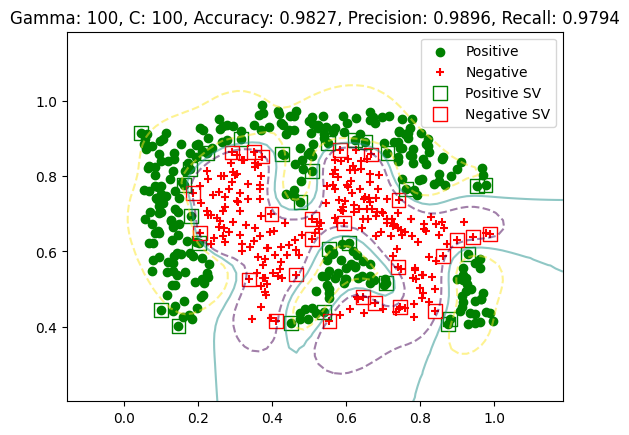

Gamma: 100, C: 1000, Accuracy: 0.9827, Precision: 0.9896, Recall: 0.9794


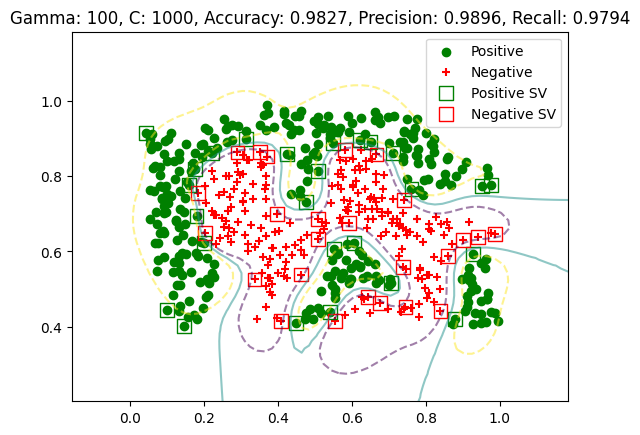

Gamma: 1000, C: 0.1, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


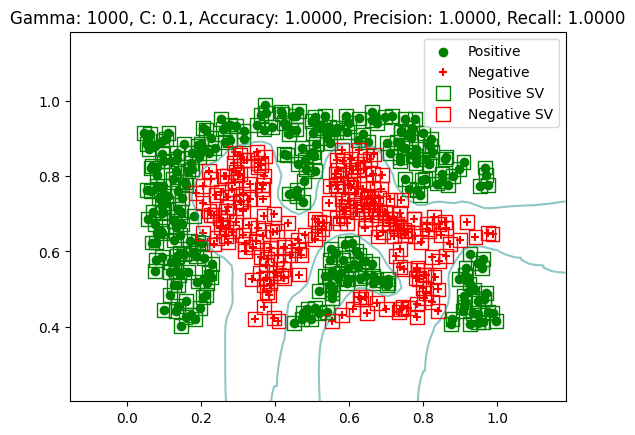

Gamma: 1000, C: 1, Accuracy: 0.9884, Precision: 0.9897, Recall: 0.9897


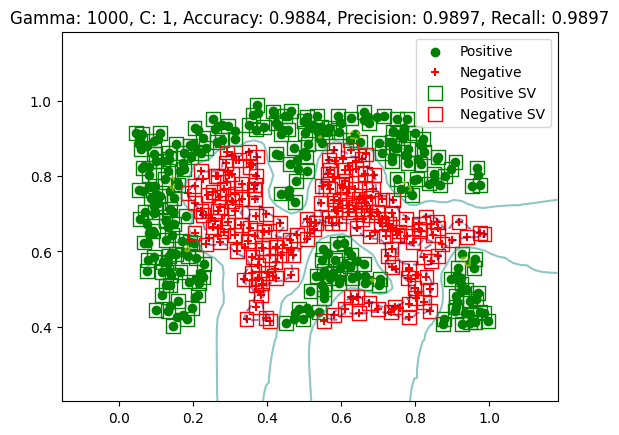

Gamma: 1000, C: 10, Accuracy: 0.9884, Precision: 0.9897, Recall: 0.9897


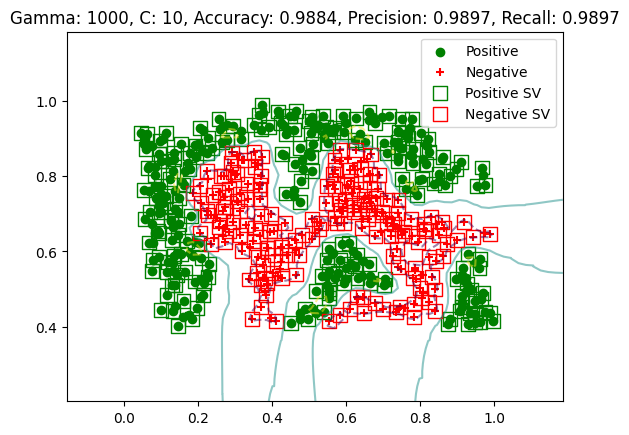

Gamma: 1000, C: 100, Accuracy: 0.9884, Precision: 0.9897, Recall: 0.9897


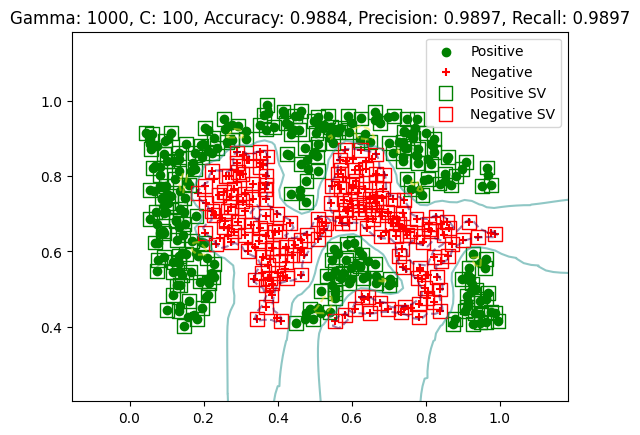

Gamma: 1000, C: 1000, Accuracy: 0.9884, Precision: 0.9897, Recall: 0.9897


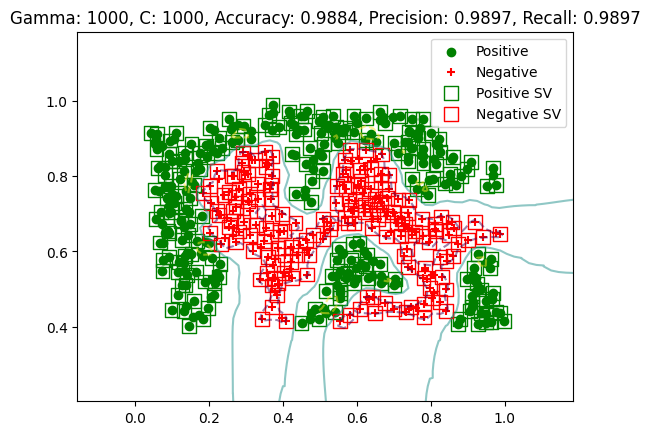

In [19]:
def rbf_kernel(x1, x2, gamma):
    return exp(-gamma * np.linalg.norm(np.array(x1)-np.array(x2))**2)

def train_svm_and_calculate_decision_boundary(x_train, y_train, gamma, C):
    model = ConcreteModel()

    N = len(x_train)
    model.alpha = Var(range(N), within=NonNegativeReals, bounds=(0, C))

    model.obj = Objective(expr=sum(model.alpha[i] for i in range(N)) - 0.5 *
                               sum(model.alpha[i]*model.alpha[j]*y_train[i]*y_train[j]*rbf_kernel(x_train[i], x_train[j], gamma)
                                   for i in range(N) for j in range(N)), sense=maximize)

    model.constraints = Constraint(expr=sum(model.alpha[i]*y_train[i] for i in range(N)) == 0)

    solver = SolverFactory('ipopt')
    solver.solve(model)

    alpha = np.array([model.alpha[i].value for i in range(N)])
    sv_indices = np.where(alpha > 1e-5)[0]

    return alpha, sv_indices

def plot_decision_boundary(alpha, x_train, y_train, sv_indices, gamma, C, accuracy, precision, recall):
    x_min, x_max = x_train[:, 0].min() - 0.2, x_train[:, 0].max() + 0.2
    y_min, y_max = x_train[:, 1].min() - 0.2, x_train[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x_test = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = sum(alpha[k] * y_train[k] * rbf_kernel(x_train[k], x_test, gamma) for k in sv_indices)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='green', marker='o', label='Positive')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='red', marker='+', label='Negative')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == 1][:, 0], x_train[sv_indices][y_train[sv_indices] == 1][:, 1],
                s=100, facecolors='none', edgecolors='green', marker='s', label='Positive SV')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == -1][:, 0], x_train[sv_indices][y_train[sv_indices] == -1][:, 1],
                s=100, facecolors='none', edgecolors='red', marker='s', label='Negative SV')
    plt.title(f"Gamma: {gamma}, C: {C}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    plt.legend()
    plt.show()

for gamma in gammas:
    for C in Cs:
        alpha, sv_indices = train_svm_and_calculate_decision_boundary(x_train, y_train, gamma, C)

        y_val_pred = np.sign([sum(alpha[k] * y_train[k] * rbf_kernel(x_train[k], x_val[i], gamma) for k in sv_indices) for i in range(len(x_val))])
        accuracy = accuracy_score(y_val, y_val_pred)  
        precision = precision_score(y_val, y_val_pred,zero_division=0)
        recall = recall_score(y_val, y_val_pred, zero_division=0)

        print(f"Gamma: {gamma}, C: {C}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        plot_decision_boundary(alpha, x_train, y_train, sv_indices, gamma, C, accuracy, precision, recall)

H:

In [20]:
data = loadmat('data2.mat')
x_train = data['X']
y = data['y']
y = y.reshape(-1)
y_train = np.ones(len(y), dtype=int)

In [21]:
y_train[y == 0] = -1

Number of support vectors:  816
Alpha values of support vectors:  [0.09999999 0.0248628  0.09999997 0.03493731 0.09999991 0.09999951
 0.1        0.03843696 0.09999982 0.07854567 0.09999978 0.1
 0.1        0.0999997  0.09999972 0.08939386 0.1        0.1
 0.09999923 0.01881037 0.09999996 0.09999999 0.1        0.09999999
 0.09999999 0.01220568 0.03431392 0.06089164 0.09999982 0.04350141
 0.09999739 0.00574671 0.09999999 0.09999999 0.09999998 0.09465823
 0.01524398 0.09999998 0.09999997 0.1        0.09999999 0.1
 0.09538317 0.09397205 0.09999985 0.07090797 0.09999999 0.09999997
 0.03924163 0.09248    0.09999939 0.09999959 0.09999977 0.1
 0.1        0.09999999 0.09999987 0.07441561 0.1        0.1
 0.09999994 0.09999985 0.09999998 0.09999998 0.09999998 0.09999977
 0.09413792 0.06891282 0.05589462 0.09999999 0.09999994 0.07754051
 0.05036193 0.06967417 0.05707288 0.1        0.1        0.09999951
 0.0202054  0.09999999 0.1        0.1        0.09999999 0.09999994
 0.03382514 0.02832245 0.079553

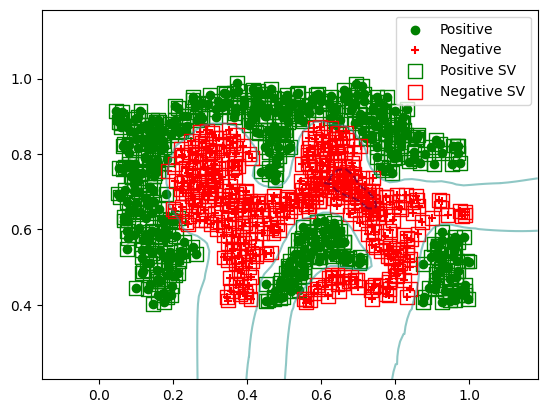

In [22]:
positive = x_train[y_train == 1]
negative = x_train[y_train == -1]

def rbf_kernel(x1, x2, gamma=1000):  # Set gamma to 1000
    return exp(-gamma * np.linalg.norm(np.array(x1)-np.array(x2))**2)

model = ConcreteModel()

N = len(x_train)
model.alpha = Var(range(N), within=NonNegativeReals, bounds=(0, 0.1))  # Set C to 0.1

model.obj = Objective(expr=sum(model.alpha[i] for i in range(N)) - 0.5 *
                           sum(model.alpha[i]*model.alpha[j]*y_train[i]*y_train[j]*rbf_kernel(x_train[i], x_train[j])
                               for i in range(N) for j in range(N)), sense=maximize)

model.constraints = Constraint(expr=sum(model.alpha[i]*y_train[i] for i in range(N)) == 0)

solver = SolverFactory('ipopt')
solver.solve(model)

alpha = np.array([model.alpha[i].value for i in range(N)])
support_vectors = x_train[alpha > 1e-5]

sv_indices = np.where(alpha > 1e-5)[0]

print("Number of support vectors: ", len(sv_indices))

print("Alpha values of support vectors: ", alpha[sv_indices])

def plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices, gamma=1000):
    x_min, x_max = x_train[:, 0].min() - 0.2, x_train[:, 0].max() + 0.2
    y_min, y_max = x_train[:, 1].min() - 0.2, x_train[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x_test = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = sum(alpha[k] * y_train[k] * rbf_kernel(x_train[k], x_test) for k in sv_indices)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='green', marker='o', label='Positive')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='red', marker='+', label='Negative')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == 1][:, 0], x_train[sv_indices][y_train[sv_indices] == 1][:, 1],
                s=100, facecolors='none', edgecolors='green', marker='s', label='Positive SV')
    plt.scatter(x_train[sv_indices][y_train[sv_indices] == -1][:, 0], x_train[sv_indices][y_train[sv_indices] == -1][:, 1],
                s=100, facecolors='none', edgecolors='red', marker='s', label='Negative SV')
    plt.legend()
    plt.show()

plot_decision_boundary_pyomo(alpha, x_train, y_train, sv_indices)

I:

In [23]:
from scipy.spatial import distance

def get_knn(x, k, x_train, y_train):
    distances = [distance.euclidean(x, xi) for xi in x_train]

    knn_indices = np.argsort(distances)[:k]

    knn_labels = y_train[knn_indices]

    predicted_label = max(set(knn_labels), key=list(knn_labels).count)

    return predicted_label

j:

In [24]:
data = loadmat('data2.mat')
x_train = data['X']
y = data['y']
y = y.reshape(-1)
y_train = np.ones(len(y), dtype=int)
y_train[y == 0] = 0

In [25]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

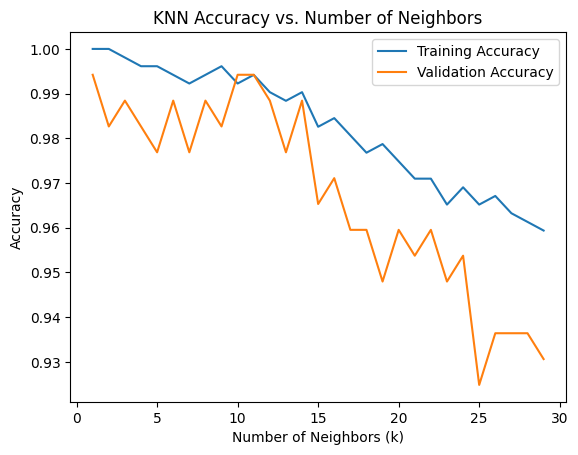

k=1: Training Accuracy = 1.0000, Validation Accuracy = 0.9942
k=2: Training Accuracy = 1.0000, Validation Accuracy = 0.9827
k=3: Training Accuracy = 0.9981, Validation Accuracy = 0.9884
k=4: Training Accuracy = 0.9961, Validation Accuracy = 0.9827
k=5: Training Accuracy = 0.9961, Validation Accuracy = 0.9769
k=6: Training Accuracy = 0.9942, Validation Accuracy = 0.9884
k=7: Training Accuracy = 0.9923, Validation Accuracy = 0.9769
k=8: Training Accuracy = 0.9942, Validation Accuracy = 0.9884
k=9: Training Accuracy = 0.9961, Validation Accuracy = 0.9827
k=10: Training Accuracy = 0.9923, Validation Accuracy = 0.9942
k=11: Training Accuracy = 0.9942, Validation Accuracy = 0.9942
k=12: Training Accuracy = 0.9903, Validation Accuracy = 0.9884
k=13: Training Accuracy = 0.9884, Validation Accuracy = 0.9769
k=14: Training Accuracy = 0.9903, Validation Accuracy = 0.9884
k=15: Training Accuracy = 0.9826, Validation Accuracy = 0.9653
k=16: Training Accuracy = 0.9845, Validation Accuracy = 0.9711
k

In [27]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1,30)

train_accuracies = []
val_accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    knn_model.fit(x_train, y_train)
    
    y_train_pred = knn_model.predict(x_train)
    
    y_val_pred = knn_model.predict(x_val)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.show()


for k, train_acc, val_acc in zip(k_values, train_accuracies, val_accuracies):
    print(f'k={k}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}')

k:

In [28]:
x_train_combined = np.concatenate((x_train, x_val), axis=0)
y_train_combined = np.concatenate((y_train, y_val), axis=0)

In [29]:
knn_model_combined = KNeighborsClassifier(n_neighbors=1)
knn_model_combined.fit(x_train_combined, y_train_combined)

KNeighborsClassifier(n_neighbors=1)

In [30]:
y_test_pred = knn_model_combined.predict(x_test)

In [31]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Combined Training + Validation Data with k=1:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

Combined Training + Validation Data with k=1:
Accuracy: 0.9884
Recall: 0.9773
Precision: 1.0000
F1 Score: 0.9885


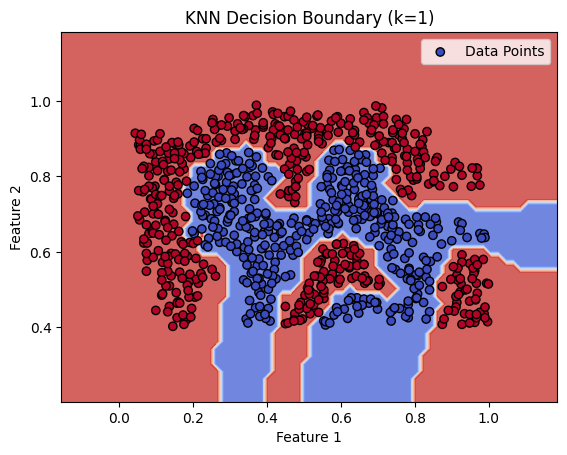

In [32]:
def plot_decision_boundary_knn(model, x_data, y_data, title):
    h = .02

    x_min, x_max = x_data[:, 0].min() - 0.2, x_data[:, 0].max() + 0.2
    y_min, y_max = x_data[:, 1].min() - 0.2, x_data[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', label='Data Points')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

data = loadmat('data2.mat')
x_train = data['X']
y = data['y']
y = y.reshape(-1)
y_train = np.ones(len(y), dtype=int)

y_train[y == 0] = -1

x_train_val, x_test, y_train_val, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

knn_model_combined = KNeighborsClassifier(n_neighbors=1)
knn_model_combined.fit(np.vstack((x_train, x_val)), np.concatenate((y_train, y_val)))

plot_decision_boundary_knn(knn_model_combined, np.vstack((x_train, x_val, x_test)), np.concatenate((y_train, y_val, y_test)), 'KNN Decision Boundary (k=1)')

I:

In [33]:
print('Best SVM:Gamma: 1000, C: 0.1, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000')
print('Best KNN: K=1, Accuracy: 0.9884, Recall: 0.9773, Precision: 1.0000')

Best SVM:Gamma: 1000, C: 0.1, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Best KNN: K=1, Accuracy: 0.9884, Recall: 0.9773, Precision: 1.0000
